# Starry phase curve

In this tutorial, we will show how to fit the phase curve of a planet whose surface is described by spherical harmonics (a model known as [starry](https://ui.adsabs.harvard.edu/abs/2019AJ....157...64L/abstract)).

```{note}
This tutorial follows [the one from starry](https://starry.readthedocs.io/en/latest/notebooks/HotJupiterPhaseCurve/). It requires some [extra packages](about.ipynb) that are not included in the `jaxoplanet` dependencies.
```

## Setup

We first setup the number of CPUs to use and enable the use of double-precision numbers with jax.

In [1]:
import jax
import numpyro

numpyro.set_host_device_count(2)
jax.config.update("jax_enable_x64", True)

We also define the true parameters of the planet's map, the one we wish to infer

In [2]:
truth = {
    "amp": 1e-3,
    "offset": 0.4,
}

## Generating the data

We will first generate our data. Here, we define a system made of a limb-darkened star transited by a large exoplanet whose surface is modeled by a dipole. Let's start with the planet surface first.

### Body surface

In *jaxoplanet*, a surface associated to certain spherical harmonics coefficients can be defined with

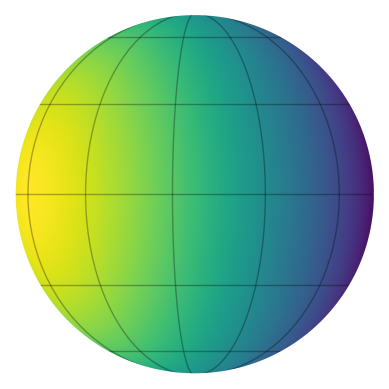

In [3]:
import math
from jaxoplanet.starry import Surface, Ylm, show_surface

# the shperical harmonics model of the surface, here a dipole
y = Ylm(
    {
        (0, 0): 1.0,
        (1, 0): 0.5,
    },
)

body_surface = Surface(
    y=y,
    period=1.0,
    phase=-math.pi + truth["offset"],
    amplitude=truth["amp"],
    normalize=False,
)

# showing the surface at a given phase
show_surface(body_surface, theta=math.pi / 2)

```{note}
By default, the surface has an inclination of $\frac{\pi}{2}$ and no rotation period. Checkout the [Surface API](jaxoplanet.starry.surface.Surface) for more details.
```

Let's plot the phase curve of this planet as it rotates around its axis. Here, as we are not dealing with a system, we will use the method [surface_light_curve](jaxoplanet.starry.light_curves.surface_light_curve)

In [4]:
import numpy as np
from jaxoplanet.starry import light_curves
import matplotlib.pyplot as plt

phase = np.linspace(0.0, 2 * np.pi, 100)

flux = jax.vmap(
    lambda phase: light_curves.surface_light_curve(
        body_surface, theta=phase + body_surface.phase
    )
)(phase)

Let's make a nice plot

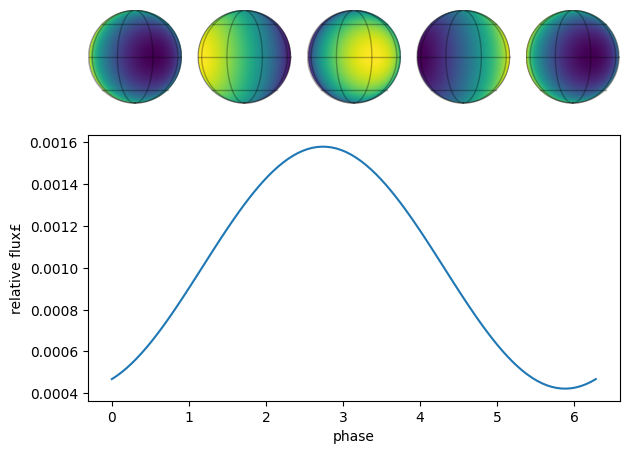

In [ ]:
n = 5
n_phases = np.linspace(phase.min(), phase.max(), n)

for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    show_surface(body_surface, n=4, ax=ax, theta=n_phases[i], white_contour=False)

ax = plt.subplot(3, n, (n + 1, n * 3))
ax.plot(phase, flux)

plt.xlabel("phase")
plt.ylabel("relative flux")
plt.tight_layout()

As we can see, the light curve maximum has an offset from the central phase of the planet's orbit.

### System and light curve

Let's now define the central body surface, which is only limb-darkened, and the full system. Here, we need to use a [SurfaceSystem](jaxoplanet.starry.orbit.SurfaceSystem), where we can pass the surfaces of the bodies along with their orbital parameters.

In [6]:
from jaxoplanet.orbits.keplerian import Central, Body
from jaxoplanet.starry.orbit import SurfaceSystem

star_surface = Surface(u=(0.4, 0.2))

system = SurfaceSystem(Central(mass=1.0, radius=1.0), star_surface)
system = system.add_body(Body(radius=0.1, period=1.0), body_surface)

Here is our final data

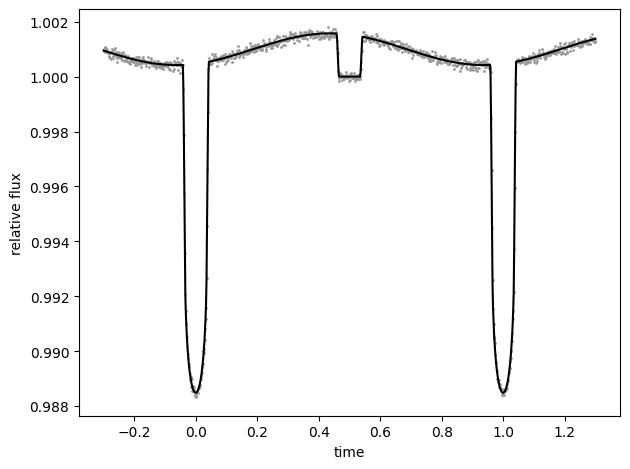

In [7]:
from jaxoplanet.starry import light_curves

time = np.linspace(-0.3, 1.3, 1000)
error = 1e-4
flux_true = light_curves.light_curve(system)(time).sum(1)
flux_data = flux_true + np.random.normal(0, error, len(time))

plt.plot(time, flux_data, ".", c="0.6", ms=2)
plt.plot(time, flux_true, c="k")
plt.xlabel("time")
plt.ylabel("relative flux")
_ = plt.tight_layout()

```{note}
[jaxoplanet.starry.light_curves.light_curve](jaxoplanet.starry.light_curves.light_curve) returns an array containing the light curve of each body, starting with the central body. For this reason, the light curve is a sum of this array over the first axis.
```

## Inference

Let's now infer the parameters of our model.


### NumPyro model

A good practice when building the numpyro model is to encapsulate the data model into a separate function, like

In [8]:
def data_model(params, time):
    y = Ylm(
        {
            (0, 0): 1.0,
            (1, 0): 0.5,
        },
    )

    # the definition of the phase here ensures that the offset is zero if the surface's
    # hot point is directly facing the star
    body_surface = Surface(
        y=y,
        period=1.0,
        normalize=False,
        amplitude=params["amp"],
        phase=2 * np.pi * params["t0"] / params["period"] + np.pi + params["offset"],
    )

    star_surface = Surface(u=(0.4, 0.2))

    system = SurfaceSystem(Central(mass=1.0, radius=1.0), star_surface)
    system = system.add_body(Body(radius=0.1, period=1.0), body_surface)

    return light_curves.light_curve(system)(time).sum(1)

Because we only infer the amplitude and offset of the planet map, the numpyro model is simply

In [9]:
import numpyro


def numpyro_model(time, error, y=None):
    log_amp = numpyro.sample("log_amp", numpyro.distributions.Normal(0, np.pi / 4))
    offset = numpyro.sample("offset", numpyro.distributions.Normal(-4.0, 2.0))
    amp = numpyro.deterministic("amp", 10**log_amp)

    params = {"amp": amp, "offset": offset, "t0": 0.0, "period": 1.0}
    y_pred = data_model(params, time)
    numpyro.sample("obs", numpyro.distributions.Normal(y_pred, error), obs=y)

### Optimization

We can now optimize the paremeters of the model

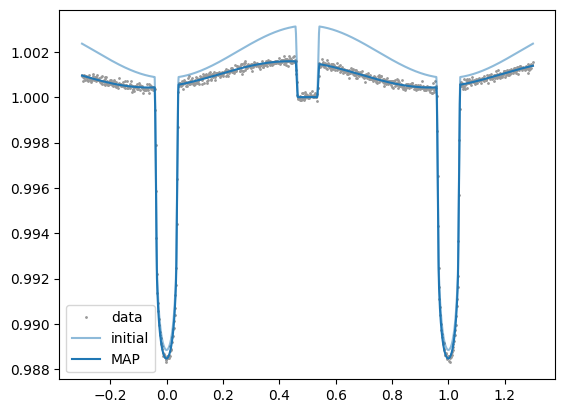

In [10]:
import numpyro_ext

init_params = {"amp": 2e-3, "offset": 0.0, "t0": 0.0, "period": 1.0}

run_optim = numpyro_ext.optim.optimize(
    numpyro_model,
    init_strategy=numpyro.infer.init_to_value(values=init_params),
)

opt_params = {
    **init_params,
    **run_optim(jax.random.PRNGKey(6), time, error, y=flux_data),
}

plt.plot(time, flux_data, ".", c="0.6", ms=2, label="data")
plt.plot(time, data_model(init_params, time), label="initial", alpha=0.5, c="C0")
plt.plot(time, data_model(opt_params, time), label="MAP", c="C0")
_ = plt.legend()

### Sampling

And finally proceed to sampling

In [11]:
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        numpyro_model,
        dense_mass=True,
        regularize_mass_matrix=False,
        init_strategy=numpyro.infer.init_to_value(values=opt_params),
    ),
    num_warmup=500,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)

sampler.run(jax.random.PRNGKey(1), time, error, flux_data)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Here is the sampling statistics summary

In [12]:
sampler.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   log_amp     -3.00      0.00     -3.00     -3.00     -3.00   2916.67      1.00
    offset      0.40      0.01      0.40      0.39      0.42   3495.66      1.00

Number of divergences: 0


And the corner plot of the inferred parameters

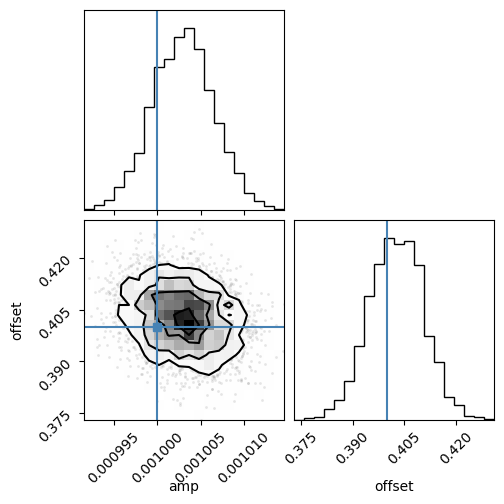

In [13]:
import corner
import arviz as az

inf_data = az.from_numpyro(sampler)
_ = corner.corner(
    inf_data, var_names=["amp", "offset"], truths=[truth["amp"], truth["offset"]]
)

This seems good!